The Bayesian Logistic regression is solved using "[Unbiased implicit variational inference](https://arxiv.org/abs/1808.02078)":

In [1]:
from functools import partial
import operator
import itertools

import jax
from jax import numpy as jnp
from jax import random
from jax import nn
from jax import lax
try:
    from jax.tree import map as tree_map
except ImportError:
    from jax import tree_map
import numpy as np
import optax
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt

from bayeslr_imbalanced import hmc


@jax.jit
def linear(W, b, x):
    """
    :param W: layer parameters of shape (fan_out, fan_in)
    :param b: layer parameters of shape (fan_out,)
    :param x: the inputs, of shape (fan_in,)
    :return: of shape (fan_out,)
    """
    return jnp.dot(W, x) + b


@jax.jit
def layer_norm_relu(gain, bias, x):
    """
    :param gain: layer parameters of shape (d,)
    :param bias: layer parameters of shape (d,)
    :param x: the inputs, of shape (d,)
    :return: of shape (d,)
    """
    mu = jnp.mean(x)
    std = jnp.std(x)
    return nn.relu((x - mu) / std * gain + bias)


@jax.jit
def get_sigma2_from_logscale(log_sigma2):
    return jnp.exp(log_sigma2 / 2)


@jax.jit
def calc_variational_posterior_mean(theta, eps):
    """
    Compute the variational posterior mean from a sampled mixing variable.

    :param theta: the neural network parameter dictionary
    :param eps: a sampled mixing variable, of shape (mixing_dim,)
    :return: the variational posterior mean of shape (latent_dim,)
    """
    mu = linear(theta['linear.1.weight'], theta['linear.1.bias'], eps)
    mu = layer_norm_relu(theta['layernorm.1.gain'], theta['layernorm.1.bias'],
                         mu)
    mu = linear(theta['linear.2.weight'], theta['linear.2.bias'], mu)
    mu = layer_norm_relu(theta['layernorm.2.gain'], theta['layernorm.2.bias'],
                         mu)
    mu = linear(theta['linear.3.weight'], theta['linear.3.bias'], mu)
    return mu


@partial(jax.jit, static_argnames=('mixing_dim', 'hidden_dim', 'latent_dim'))
def init_variational_net_and_sigma2(key, mixing_dim, hidden_dim, latent_dim):
    """
    Initialize the variational distribution network parameters. The linear
    layer weights are initialized in Kaiming normal:
    Gaussian(0, (gain/sqrt(fan_in))**2 I)

    :param key: the random key
    :param mixing_dim: the dimension of the mixing variable, the first fan-in
    :param hidden_dim: the dimension of the hidden layers
    :param latent_dim: the dimension of the latent variable
    :return: the parameter dictionary, and the log variational posterior
             variances
    """
    key_w1, key_w2, key_w3, key_sigma = random.split(key, 4)
    gain = np.sqrt(2)  # gain of ReLU
    theta = {
        'linear.1.weight':
        random.normal(key_w1, shape=(hidden_dim, mixing_dim)) * gain
        / np.sqrt(mixing_dim),
        'linear.1.bias':
        jnp.zeros(hidden_dim),
        'layernorm.1.gain':
        jnp.ones(hidden_dim),
        'layernorm.1.bias':
        jnp.zeros(hidden_dim),
        'linear.2.weight':
        random.normal(key_w2, shape=(hidden_dim, hidden_dim)) * gain
        / np.sqrt(hidden_dim),
        'linear.2.bias':
        jnp.zeros(hidden_dim),
        'layernorm.2.gain':
        jnp.ones(hidden_dim),
        'layernorm.2.bias':
        jnp.zeros(hidden_dim),
        'linear.3.weight':
        random.normal(key_w3, shape=(latent_dim, hidden_dim)) * gain
        / np.sqrt(hidden_dim),
        'linear.3.bias':
        jnp.zeros(latent_dim),
    }
    log_sigma2 = random.normal(key_sigma, shape=(latent_dim,)) * 0.1 - 5
    return theta, log_sigma2


@jax.jit
def transform_variational_posterior(theta, log_sigma2, eps, u):
    """
    Transform eps and u to a sample z of the variational posterior.
    The mixing variable eps should be drawn from Gaussian(0, I) of dimension
    ``mixing_dim``, and the latent source variable should be drawn from
    Gaussian(0, I) of dimension ``latent_dim``.

    :param theta: the neural network parameter dictionary
    :param log_sigma2: the log posterior variances, of shape (latent_dim,)
    :param eps: a sampled mixing variable, of shape (mixing_dim,)
    :param u: a sampled standard Gaussian to be reparameterized, of shape
           (latent_dim,)
    :return: one latent sample of shape (latent_dim,)
    """
    mu = calc_variational_posterior_mean(theta, eps)
    std = jnp.sqrt(get_sigma2_from_logscale(log_sigma2))
    z = mu + std * u
    return z


@jax.jit
def log_variational_reparam_density(
    mu,
    log_sigma2,
    z,
):
    """
    Evaluate the log density of the variational reparameterization conditional:
    q(z | mu, log_sigma2), given its sampled parameters.

    :param mu: the posterior mean, of shape (latent_dim,)
    :param log_sigma2: the log posterior variances, of shape (latent_dim,)
    :param z: a latent sample of shape (latent_dim,)
    :return: the log density
    """
    sigma2 = get_sigma2_from_logscale(log_sigma2)
    return -jnp.dot((z - mu) / sigma2, z - mu) / 2


@jax.jit
def log_joint_variational_density(theta, log_sigma2, z, eps):
    """
    Evaluate the log joint variational density.

    :param theta: the neural network parameter dictionary
    :param log_sigma2: the log posterior variances, of shape (latent_dim,)
    :param z: a latent sample of shape (latent_dim,)
    :param eps: a sampled mixing variable, of shape (mixing_dim,)
    :return: the log density, and the sampled variational posterior mean
    """
    t1 = -jnp.dot(eps, eps) / 2
    mu = calc_variational_posterior_mean(theta, eps)
    t2 = log_variational_reparam_density(mu, log_sigma2, z)
    return t1 + t2, mu


@partial(
    jax.jit,
    static_argnames=(
        'hmc_n_integration_steps',
        'hmc_n_warmup',
        'hmc_n_samples',
    ),
)
def estimate_log_marginal_variational_density_grad(
    key,
    theta,
    log_sigma2,
    z,
    eps0,
    hmc_mass,
    hmc_n_integration_steps,
    hmc_step_size,
    hmc_n_warmup,
    hmc_n_samples,
):
    """
    Sample from the reverse conditional by HMC starting from the position
    ``eps0``, and estimate the gradient of the log of the marginal variational
    density log q_theta(z | eps) with respect to z. The reverse conditional is
    given by q_theta(eps | z).

    :param key: the random key
    :param theta: the neural network parameter dictionary
    :param log_sigma2: the log posterior variances, of shape (latent_dim,)
    :param z: a latent sample of shape (latent_dim,)
    :param eps0: a sampled mixing variable, of shape (mixing_dim,)
    :param hmc_mass: the kinematic mass diagonal of HMC
    :param hmc_n_integration_steps: number of integration steps in HMC
    :param hmc_step_size: the step size in HMC
    :param hmc_n_warmup: number of warmup steps in HMC
    :parma hmc_n_samples: number of sampling steps in HMC
    :return: the gradient of shape (latent_dim,)
    """
    logdensity_fun = partial(log_joint_variational_density, theta, log_sigma2,
                             z)

    states = hmc.hmc(key, eps0, logdensity_fun, hmc_mass,
                     hmc_n_integration_steps, hmc_step_size,
                     hmc_n_warmup + hmc_n_samples)
    z_grad = jnp.mean(
        jax.vmap(
            jax.grad(log_variational_reparam_density, argnums=2),
            in_axes=(0, None, None))(states.aux[hmc_n_warmup:], log_sigma2, z),
        axis=0)
    return z_grad


# @partial(jax.jit, static_argnames=('input_dim', 'n_class'))
def split_z_into_weights_and_biases(z, input_dim, n_class):
    """
    Split z into weights and biases. input_dim and n_class have to be static.

    :param z: the latent variable, of shape (latent_dim,)
    :param input_dim: the input_dim
    :param n_class: number of classes
    :return: weights of shape (n_class, input_dim), and biases of shape
             (n_class,)
    """
    latent_dim = z.shape[0]
    head = np.arange(input_dim, latent_dim - n_class, input_dim)
    tail = np.arange(latent_dim - n_class, latent_dim, 1)
    ind = np.concatenate((head, tail))
    lst = jnp.split(z, ind)
    head, tail = lst[:-n_class], lst[-n_class:]
    head = jnp.stack(head)
    tail = jnp.concatenate(tail)
    return head, tail


# @jax.jit
def log_likelihood(x, y, z_weights, z_biases):
    """
    Compute the log of the likelihood p(y | z; x).

    :param x: the inputs, of shape (input_dim,)
    :param y: the observation, one hot vector of shape (n_class,)
    :param z_weights: the weights of each class, of shape (n_class, input_dim)
    :param z_biases: the biases of each class, of shape (n_class,)
    :return: the log likelihood, a scalar
    """
    def log_likelihood_unnormalized(y):
        weights = jnp.dot(y, z_weights)
        bias = jnp.dot(y, z_biases)
        return jnp.dot(x, weights) + bias

    return (log_likelihood_unnormalized(y) - nn.logsumexp(
        jax.vmap(log_likelihood_unnormalized)(jnp.eye(y.shape[0]))))


# @partial(jax.jit, static_argnames=('input_dim', 'n_class'))
def log_joint_model_density_over_batch(
    x,
    y,
    z,
    input_dim,
    n_class,
    dataset_size,
):
    """
    Compute the log of the joint model density p(y, z; x) over a batch (x, y).
    ``input_dim`` and ``n_class`` have to be static. The likelihood for each
    sample are summed, divided by ``batch_size``, and multiplied by
    ``dataset_size``.  To just sum the likelihood, pass the ``batch_size`` to
    ``dataset_size``.

    :param x: the inputs, of shape (batch_size, input_dim)
    :param y: the observations, of shape (batch_size, n_class)
    :param z: the latent, of shape (latent_dim,)
    :param input_dim: the input_dim
    :param n_class: number of classes
    :param dataset_size: the size of the underlying dataset
    :return: the log density, a scalar
    """
    weights, biases = split_z_into_weights_and_biases(z, input_dim, n_class)
    # log_prior is to be specified later
    return (log_prior(z) + dataset_size * jnp.mean(
        jax.vmap(log_likelihood, in_axes=(0, 0, None, None))
        (x, y, weights, biases)))


# @partial(
#     jax.jit,
#     static_argnames=(
#         'dataset_size',
#         'input_dim',
#         'n_class',
#         'hmc_n_integration_steps',
#         'hmc_n_warmup',
#         'hmc_n_samples',
#     ),
# )
@partial(
    jax.vmap,
    in_axes=(
        0,  # key
        None,
        None,
        None,
        None,
        0,  # eps
        0,  # u
        None,
        None,
        None,
        None,
        None,
        None,
        None,
        None,
    ),
)
def estimate_elbo_grad(
    key,
    theta,
    log_sigma2,
    x,
    y,
    eps,
    u,
    dataset_size,
    input_dim,
    n_class,
    hmc_mass,
    hmc_n_integration_steps,
    hmc_step_size,
    hmc_n_warmup,
    hmc_n_samples,
):
    """
    Compute the ELBO gradient w.r.t. theta and log_sigma2.

    :param key: the random key
    :param theta: the neural network parameter dictionary
    :param log_sigma2: the log posterior variances, of shape (latent_dim,)
    :param x: the inputs, of shape (batch_size, input_dim)
    :param y: the observations, of shape (batch_size, n_class)
    :param eps: a sampled mixing variable, of shape (mixing_dim,)
    :param u: a sampled standard Gaussian to be reparameterized, of shape
           (latent_dim,)
    :param dataset_size: the size of the underlying dataset
    :param input_dim: the input_dim
    :param n_class: number of classes
    :param hmc_mass: the kinematic mass diagonal of HMC
    :param hmc_n_integration_steps: number of integration steps in HMC
    :param hmc_step_size: the step size in HMC
    :param hmc_n_warmup: number of warmup steps in HMC
    :parma hmc_n_samples: number of sampling steps in HMC
    :return: the gradient w.r.t. theta, and the gradient w.r.t. log_sigma2
    """
    z, vjp_fun = jax.vjp(
        partial(transform_variational_posterior, eps=eps, u=u), theta,
        log_sigma2)

    # Compute the gradient term corresponding to the model.
    z_grad = jax.grad(
        log_joint_model_density_over_batch, argnums=2)(x, y, z, input_dim,
                                                       n_class, dataset_size)
    theta_grad_model, log_sigma2_grad_model = vjp_fun(z_grad)

    # Compute the gradient term corresponding to the entropy.
    z_grad = estimate_log_marginal_variational_density_grad(
        key, theta, log_sigma2, z, eps, hmc_mass, hmc_n_integration_steps,
        hmc_step_size, hmc_n_warmup, hmc_n_samples)
    theta_grad_entropy, log_sigma2_grad_entropy = vjp_fun(-z_grad)

    theta_grad = tree_map(operator.add, theta_grad_model,
                              theta_grad_entropy)
    log_sigma2_grad = tree_map(operator.add, log_sigma2_grad_model,
                                   log_sigma2_grad_entropy)
    return theta_grad, log_sigma2_grad


# @partial(jax.jit, static_argnames=('n_mc_joint_variational', 'mixing_dim'))
def estimate_log_marginal_variational_density(
    key,
    z,
    theta,
    log_sigma2,
    n_mc_joint_variational,
    mixing_dim,
):
    """
    Estimate the log of the marginal variational density q_theta(z) by Monte
    Carlo sampling.

    :param key: the random key
    :param z: a latent sample of shape (latent_dim,)
    :param theta: the neural network parameter dictionary
    :param log_sigma2: the log posterior variances, of shape (latent_dim,)
    :param n_mc_joint_variational: number of samples to draw to estimate the
           inner log marginal variational density
    :param mixing_dim: the dimension of the mixing variable
    :return: the approximate marginal density
    """
    eps = random.normal(key, shape=(n_mc_joint_variational, mixing_dim))
    mu = jax.vmap(
        calc_variational_posterior_mean, in_axes=(None, 0))(theta, eps)
    logdens = jax.vmap(
        log_variational_reparam_density,
        in_axes=(0, None, None))(mu, log_sigma2, z)
    return -jnp.log(n_mc_joint_variational) + nn.logsumexp(logdens)


# @partial(
#     jax.jit,
#     static_argnames=(
#         'n_mc_elbo',
#         'n_mc_joint_variational',
#         'input_dim',
#         'mixing_dim',
#         'latent_dim',
#         'n_class',
#     ),
# )
def estimate_elbo(
    key,
    theta,
    log_sigma2,
    x,
    y,
    n_mc_elbo,
    n_mc_joint_variational,
    input_dim,
    mixing_dim,
    latent_dim,
    n_class,
):
    """
    Estimate the ELBO by Monte Carlo sampling.

    :param key: the random key
    :param theta: the neural network parameter dictionary
    :param log_sigma2: the log posterior variances, of shape (latent_dim,)
    :param x: the inputs, of shape (n_sample, input_dim)
    :param y: the observations, of shape (n_sample, n_class)
    :param n_mc_elbo: number of samples to draw to estimate the ELBO
    :param n_mc_joint_variational: number of samples to draw to estimate the
           inner log marginal variational density
    :param input_dim: the input_dim
    :param mixing_dim: the dimension of the mixing variable
    :param latent_dim: the dimension of the latent variable
    :param n_class: number of classes
    :return: the approximate ELBO
    """
    def body_fun(_carry, xs):
        key, u, eps = xs
        z = transform_variational_posterior(theta, log_sigma2, eps, u)
        logden1 = log_joint_model_density_over_batch(x, y, z, input_dim,
                                                     n_class, n_sample)
        logden2 = estimate_log_marginal_variational_density(
            key, z, theta, log_sigma2, n_mc_joint_variational, mixing_dim)
        return None, logden1 - logden2

    n_sample = x.shape[0]
    key, key_u, key_eps = random.split(key, 3)
    u = random.normal(key_u, shape=(n_mc_elbo, latent_dim))
    eps = random.normal(key_eps, shape=(n_mc_elbo, mixing_dim))
    keys = random.split(key, n_mc_elbo)
    _, logdens = lax.scan(body_fun, None, (keys, u, eps))
    return jnp.mean(logdens)


# @partial(
#     jax.jit,
#     static_argnames=(
#         'n_mc_pp',
#         'input_dim',
#         'mixing_dim',
#         'latent_dim',
#         'n_class',
#     ),
# )
def estimate_predictive_posterior(
    key,
    theta,
    log_sigma2,
    x,
    n_mc_pp,
    input_dim,
    mixing_dim,
    latent_dim,
    n_class,
):
    """
    Estimate the log of the predictive posterior p(y=? | x, D) by Monte Carlo
    sampling.

    :param key: the random key
    :param theta: the neural network parameter dictionary
    :param log_sigma2: the log posterior variances, of shape (latent_dim,)
    :param x: the inputs, of shape (n_sample, input_dim)
    :param n_mc_pp: number of samples to draw
    :param input_dim: the input_dim
    :param mixing_dim: the dimension of the mixing variable
    :param latent_dim: the dimension of the latent variable
    :param n_class: number of classes
    :return: the approximate log predictive posterior of shape
             (n_sample, n_class)
    """
    def body_fun(_carry, xs):
        u, eps = xs
        z = transform_variational_posterior(theta, log_sigma2, eps, u)
        weights, biases = split_z_into_weights_and_biases(
            z, input_dim, n_class)
        ll = jax.vmap(
            jax.vmap(log_likelihood, in_axes=(None, 0, None, None)),
            in_axes=(0, None, None, None))(x, jnp.eye(n_class), weights,
                                           biases)
        return None, ll

    key_u, key_eps = random.split(key, 2)
    u = random.normal(key_u, shape=(n_mc_pp, latent_dim))
    eps = random.normal(key_eps, shape=(n_mc_pp, mixing_dim))
    _, pps = lax.scan(body_fun, None, (u, eps))
    return -jnp.log(n_mc_pp) + nn.logsumexp(pps, axis=0)


# @partial(
#     jax.jit,
#     static_argnames=(
#         'n_mc_pp',
#         'input_dim',
#         'mixing_dim',
#         'latent_dim',
#         'n_class',
#     ),
# )
def eval_accuracy(
    key,
    theta,
    log_sigma2,
    x,
    y,
    n_mc_pp,
    input_dim,
    mixing_dim,
    latent_dim,
    n_class,
):
    """
    Evaluate accuracy of the learned model.

    :param key: the random key
    :param theta: the neural network parameter dictionary
    :param log_sigma2: the log posterior variances, of shape (latent_dim,)
    :param x: the inputs, of shape (n_sample, input_dim)
    :param y: the observations, of shape (n_sample, n_class)
    :param n_mc_pp: number of samples to draw
    :param input_dim: the input_dim
    :param mixing_dim: the dimension of the mixing variable
    :param latent_dim: the dimension of the latent variable
    :param n_class: number of classes
    :return: the accuracy (a scalar)
    """
    pp = estimate_predictive_posterior(key, theta, log_sigma2, x, n_mc_pp,
                                       input_dim, mixing_dim, latent_dim,
                                       n_class)
    return jnp.mean(jnp.argmax(pp, axis=1) == jnp.argmax(y, axis=1))


def collate_fn(batch, n_class):
    """
    The collate_fn for pytorch DataLoader.

    :param batch: a batch of tuple (x, y)
    :param n_class: number of classes
    :return: (xs, ys)
    """
    xs, ys = [], []
    for x, y in batch:
        xs.append(jnp.ravel(jnp.asarray(x)))
        ys.append(nn.one_hot(jnp.asarray(y), n_class))
    xs = jnp.stack(xs)
    ys = jnp.stack(ys)
    return xs, ys


def train_one_epoch(
    train_loader,
    optimizer,
    state,
    n_mc_elbo_grad,
    n_mc_elbo,
    n_mc_joint_variational,
    input_dim,
    mixing_dim,
    latent_dim,
    n_class,
    dataset_size,
    hmc_mass,
    hmc_n_integration_steps,
    hmc_step_size,
    hmc_n_warmup,
    hmc_n_samples,
    print_update_to_data_ratio: bool,
):
    key, theta, log_sigma2, opt_state = state
    for ba, (x, y) in enumerate(train_loader, 1):
        key, subk_eps, subk_u, subk_elbo_grad, subk_elbo = random.split(key, 5)
        eps = random.normal(subk_eps, shape=(n_mc_elbo_grad, mixing_dim))
        u = random.normal(subk_u, shape=(n_mc_elbo_grad, latent_dim))
        subk_elbo_grad = random.split(subk_elbo_grad, n_mc_elbo_grad)
        grads = tree_map(
            lambda a: jnp.mean(a, axis=0),
            estimate_elbo_grad(subk_elbo_grad, theta, log_sigma2, x, y, eps, u,
                               dataset_size, input_dim, n_class, hmc_mass,
                               hmc_n_integration_steps, hmc_step_size,
                               hmc_n_warmup, hmc_n_samples))
        # We want to maximize the ELBO, but optax does minimization. Thus, we
        # need to negate the gradients.
        grads = tree_map(lax.neg, grads)
        updates, opt_state = optimizer.update(grads, opt_state)
        # Compute the update-to-data ratio.
        theta_utd, log_sigma2_utd = tree_map(update_to_data_ratio, updates,
                                             (theta, log_sigma2))
        theta, log_sigma2 = optax.apply_updates((theta, log_sigma2), updates)
        elbo = estimate_elbo(subk_elbo, theta, log_sigma2, x, y, n_mc_elbo,
                             n_mc_joint_variational, input_dim, mixing_dim,
                             latent_dim, n_class)
        print(f'  ba {ba:>5} elbo={elbo:.3e}')
        if print_update_to_data_ratio:
            print('  ## theta_utd:', theta_utd)
            print('  ## log_sigma2_utd:', log_sigma2_utd)
    return key, theta, log_sigma2, opt_state


def get_param(
    params,
    name: str,
    default=None,
):
    """Get parameter from parameter dictionary/object-like."""
    try:
        if hasattr(params, '__getitem__'):
            try:
                value = params[name]
            except TypeError:
                # Happens when trying to index a namedtuple with string.
                value = getattr(params, name)
        else:
            value = getattr(params, name)
        if value is None:
            if default is None:
                raise KeyError(f'parameter {name} does not exist')
            return default
        return value
    except (KeyError, AttributeError) as err:
        if default is None:
            raise KeyError(f'parameter {name} does not exist') from err
        return default


def update_to_data_ratio(update, data):
    update = jnp.ravel(update)
    data = jnp.ravel(data)
    return 0.5 * (
        jnp.log10(jnp.dot(update, update)) - jnp.log10(jnp.dot(data, data)))


def train_and_eval_elbo(key, trainset, validset, params):
    """
    Train and evaluate ELBO on random subset of the trainset.

    :param key: the random key
    :param trainset: a list like object that returns (x, y) tuple on
           __getitem__(index), where x is of shape (input_dim,) and y is
           the class label (an integer)
    :param validset: same type as ``trainset``, except for validation purpose.
           Note that all ``validset`` will be loaded at once, so make sure
           they fit into memory
    :param params: training hyperparameters and options
    :return: (historical ELBOs, historical accuracies, theta, log_sigma2)
    """
    mixing_dim = get_param(params, 'mixing_dim')
    hidden_dim = get_param(params, 'hidden_dim')
    input_dim = get_param(params, 'input_dim')
    n_class = get_param(params, 'n_class')
    latent_dim = (input_dim + 1) * n_class
    lr = get_param(params, 'lr')
    n_epoch = get_param(params, 'n_epoch')
    batch_size = get_param(params, 'batch_size', 64)
    n_mc_elbo_grad = get_param(params, 'n_mc_elbo_grad')
    n_mc_elbo = get_param(params, 'n_mc_elbo')
    n_mc_pp = get_param(params, 'n_mc_pp', n_mc_elbo)
    n_mc_joint_variational = get_param(params, 'n_mc_joint_variational')
    n_train_batch = get_param(params, 'n_train_batch', -1)
    hmc_mass = get_param(params, 'hmc_mass', jnp.ones(mixing_dim))
    hmc_n_integration_steps = get_param(params, 'hmc_n_integration_steps')
    hmc_step_size = get_param(params, 'hmc_step_size', 1e-3)
    hmc_n_warmup = get_param(params, 'hmc_n_warmup', 5)
    hmc_n_samples = get_param(params, 'hmc_n_samples', 5)
    print_update_to_data_ratio = get_param(params,
                                           'print_update_to_data_ratio', True)

    key, key_opt, key_init = random.split(key, 3)
    train_loader = DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=partial(collate_fn, n_class=n_class))
    valid_loader = DataLoader(
        validset,
        batch_size=len(validset),
        shuffle=False,
        collate_fn=partial(collate_fn, n_class=n_class))
    theta, log_sigma2 = init_variational_net_and_sigma2(
        key_init, mixing_dim, hidden_dim, latent_dim)
    optimizer = optax.adam(learning_rate=lr)
    opt_state = optimizer.init((theta, log_sigma2))
    state = key_opt, theta, log_sigma2, opt_state

    # Get the evaluation data.
    x_valid, y_valid = next(iter(valid_loader))
    # Don't need it any longer.
    del valid_loader

    # Evaluate once before training.
    elbos = []
    accs = []
    key, key_elbo, key_acc = random.split(key, 3)
    elbo = estimate_elbo(key_elbo, theta, log_sigma2, x_valid, y_valid,
                         n_mc_elbo, n_mc_joint_variational, input_dim,
                         mixing_dim, latent_dim, n_class)
    acc = eval_accuracy(key_acc, theta, log_sigma2, x_valid, y_valid, n_mc_pp,
                        input_dim, mixing_dim, latent_dim, n_class)
    print(f'ep {0:>3} elbo={elbo:.3e} acc={acc:.3f}')
    elbos.append(elbo)
    accs.append(acc)

    for ep in range(1, n_epoch + 1):
        state = train_one_epoch(
            train_loader if n_train_batch == -1 else itertools.islice(
                iter(train_loader), n_train_batch), optimizer, state,
            n_mc_elbo_grad, n_mc_elbo, n_mc_joint_variational, input_dim,
            mixing_dim, latent_dim, n_class,
            len(train_loader.dataset) if n_train_batch == -1 else min(
                len(train_loader.dataset), n_train_batch * batch_size),
            hmc_mass, hmc_n_integration_steps, hmc_step_size, hmc_n_warmup,
            hmc_n_samples, print_update_to_data_ratio)
        _, theta, log_sigma2, _ = state
        key, key_elbo, key_acc = random.split(key, 3)
        elbo = estimate_elbo(key_elbo, theta, log_sigma2, x_valid, y_valid,
                             n_mc_elbo, n_mc_joint_variational, input_dim,
                             mixing_dim, latent_dim, n_class)
        acc = eval_accuracy(key_acc, theta, log_sigma2, x_valid, y_valid,
                            n_mc_pp, input_dim, mixing_dim, latent_dim,
                            n_class)
        print(f'ep {ep:>3} elbo={elbo:.3e} acc={acc:.3f}')
        elbos.append(elbo)
        accs.append(acc)
    _, theta, log_sigma2, _ = state
    return jnp.array(elbos), jnp.array(accs), theta, log_sigma2

Load the dataset.
The data was generated from `scikit-learn`'s [`make_classification`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) function.

In [2]:
X = np.array([[-0.46601866,  1.18801609],
       [ 0.53858625,  0.60716392],
       [-0.97431137,  0.69753311],
       [-1.09220402,  0.87799492],
       [-2.03843356,  0.28665154],
       [-0.34062009,  0.79352777],
       [-1.16225216,  0.79350459],
       [ 0.19419328,  1.60986703],
       [ 0.41018415,  1.54828838],
       [-0.61113336,  0.99020048],
       [ 0.08837677,  0.95373644],
       [-1.77183232, -0.12717568],
       [-0.54560628,  1.07613052],
       [-1.69901425,  0.55489764],
       [-0.7449788 ,  0.7519103 ],
       [-1.84473763,  0.55248995],
       [-0.50824943,  1.08964891],
       [-1.35655196,  0.7102918 ],
       [-0.71295569,  0.38030989],
       [ 0.0582823 ,  1.35158484],
       [-2.74743505, -0.18849513],
       [-2.36125827, -0.22542297],
       [ 0.28512568,  1.52124326],
       [-0.67059538,  0.61188467],
       [-1.08310962,  0.57068698],
       [-1.59421684,  0.32055693],
       [-0.58608561,  0.98441983],
       [ 0.91449962,  1.74231742],
       [-1.78271812,  0.25676529],
       [-0.30880495,  0.98633121],
       [-0.80196522,  0.56542478],
       [-1.64551419,  0.2527351 ],
       [ 0.88404065,  1.80009243],
       [ 0.07752252,  1.19103008],
       [ 0.01499115,  1.35642701],
       [-1.37772455,  0.58176578],
       [-0.9893581 ,  0.6000557 ],
       [-0.20708577,  0.97773425],
       [-0.97487675,  0.67788572],
       [-0.84898247,  0.76214066],
       [-2.87107864,  0.01823837],
       [-1.52762479,  0.15224236],
       [-1.19066619,  0.61716677],
       [-0.78719074,  1.22733157],
       [ 0.37887222,  1.38907542],
       [-0.29892079,  1.20534091],
       [-1.21904812,  0.45126808],
       [-0.01954643,  1.00443244],
       [-2.7534539 , -0.41174779],
       [ 0.00290918,  1.19376387],
       [-0.3465645 ,  0.97372693],
       [-0.38706669,  0.98612011],
       [-0.3909804 ,  1.1737113 ],
       [ 0.67985963,  1.57038317],
       [-1.5574845 ,  0.38938231],
       [-0.70276487,  0.84873314],
       [-0.77152456,  1.24328845],
       [-0.78685252,  0.71866813],
       [-1.58251503,  0.47314274],
       [-0.86990291,  1.01246542],
       [-0.76296641,  1.03057172],
       [-1.46908977,  0.50048994],
       [ 0.41590518,  1.35808005],
       [-0.23171796,  0.97466644],
       [-0.35599838,  1.05651836],
       [-1.86300113,  0.31105633],
       [-1.06979785,  0.89343042],
       [ 0.89051152,  1.36968058],
       [-1.64250124,  0.5395521 ],
       [ 0.19072792,  1.39594182],
       [-0.68980859,  1.51412568],
       [-0.66216014,  0.94064958],
       [-1.98324693,  0.36500688],
       [-1.77543305,  0.48759471],
       [ 0.99143992,  1.53242166],
       [-2.03402523,  0.27661546],
       [-0.98138839,  0.86047666],
       [ 0.86594322,  1.60352598],
       [-1.25510995,  0.40788484],
       [-1.28207069,  0.55164356],
       [-0.50983219,  1.05505834],
       [ 0.98003606,  0.56171673],
       [-1.86097117,  0.44004685],
       [-1.09945843,  0.63380337],
       [-1.44294885,  0.18391039],
       [-1.60512757,  0.25456073],
       [ 0.5505329 ,  1.63447114],
       [-1.13622159,  0.87658095],
       [-0.18029101,  0.98458234],
       [-1.48031015,  0.3667454 ],
       [ 0.94295697,  1.51965296],
       [-1.94413955,  0.257857  ],
       [-1.92812486, -0.15406208],
       [-0.28437139,  0.8520255 ],
       [-0.95551392,  0.28517945],
       [-1.44252631,  0.5455637 ],
       [-0.22064889,  1.33439538],
       [-1.52749019,  0.50443876],
       [ 0.757785  ,  0.42124458],
       [-0.49536512,  0.9627005 ]])
y = np.array([1,
       0,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       0,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       0,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       0,
       1,
       1,
       1,
       1,
       0,
       1,
       1,
       0,
       1])

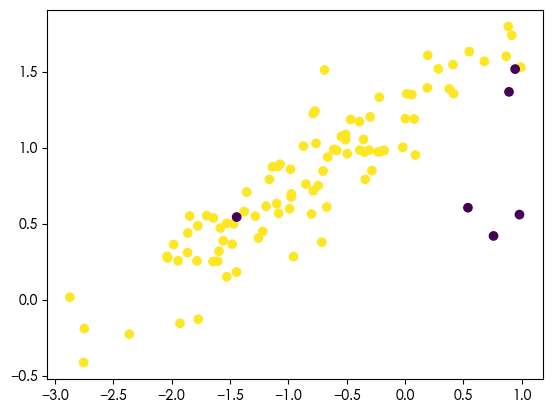

In [3]:
plt.scatter(X[:, 0], X[:, 1], c=y);

In [4]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.X)

data = MyDataset(X, y)

Set UIVI hyperparameters, and initialize the random key.

In [5]:
key = random.key(12345)

params = {
    'mixing_dim': 5,
    'hidden_dim': 10,
    'input_dim': 2,
    'n_class': 2,
    'lr': 8e-3,
    'n_epoch': 50,
    'batch_size': 128,
    'n_train_batch': -1,
    'n_mc_elbo_grad': 1,
    'n_mc_elbo': 100,
    'n_mc_pp': 1_000,
    'n_mc_joint_variational': 10_000,
    'hmc_n_integration_steps': 10,
    'hmc_n_warmup': 5,
    'hmc_n_samples': 5,
    'print_update_to_data_ratio': False,
}

## Uninformative prior

In [6]:
def log_prior(z):
    return -jnp.dot(z, z) / 2

Learn the model and make prediction.

In [7]:
_, _, theta, log_sigma2 = train_and_eval_elbo(key, data, data, params)
# To raise the resolution, change 500 to, e.g. 800, which also increase memory footprint.
xx, yy = np.meshgrid(np.linspace(-5, 4, 500), np.linspace(-4, 4, 500))
x = np.c_[xx.ravel(), yy.ravel()]
y_prob = estimate_predictive_posterior(
    key, theta, log_sigma2, x, params['n_mc_pp'], params['input_dim'], params['mixing_dim'],
    (params['input_dim'] + 1) * params['n_class'], params['n_class'])

ep   0 elbo=-5.676e+01 acc=0.880
  ba     1 elbo=-5.659e+01
ep   1 elbo=-5.391e+01 acc=0.870
  ba     1 elbo=-5.312e+01
ep   2 elbo=-5.382e+01 acc=0.880
  ba     1 elbo=-5.848e+01
ep   3 elbo=-6.356e+01 acc=0.880
  ba     1 elbo=-5.008e+01
ep   4 elbo=-4.686e+01 acc=0.880
  ba     1 elbo=-5.252e+01
ep   5 elbo=-4.731e+01 acc=0.890
  ba     1 elbo=-4.510e+01
ep   6 elbo=-4.246e+01 acc=0.900
  ba     1 elbo=-4.564e+01
ep   7 elbo=-3.905e+01 acc=0.920
  ba     1 elbo=-4.267e+01
ep   8 elbo=-3.995e+01 acc=0.930
  ba     1 elbo=-3.933e+01
ep   9 elbo=-3.914e+01 acc=0.940
  ba     1 elbo=-3.526e+01
ep  10 elbo=-3.923e+01 acc=0.940
  ba     1 elbo=-3.338e+01
ep  11 elbo=-3.213e+01 acc=0.940
  ba     1 elbo=-2.968e+01
ep  12 elbo=-3.134e+01 acc=0.940
  ba     1 elbo=-2.868e+01
ep  13 elbo=-2.887e+01 acc=0.940
  ba     1 elbo=-2.718e+01
ep  14 elbo=-2.689e+01 acc=0.940
  ba     1 elbo=-2.764e+01
ep  15 elbo=-2.631e+01 acc=0.940
  ba     1 elbo=-2.595e+01
ep  16 elbo=-2.520e+01 acc=0.940
  ba   

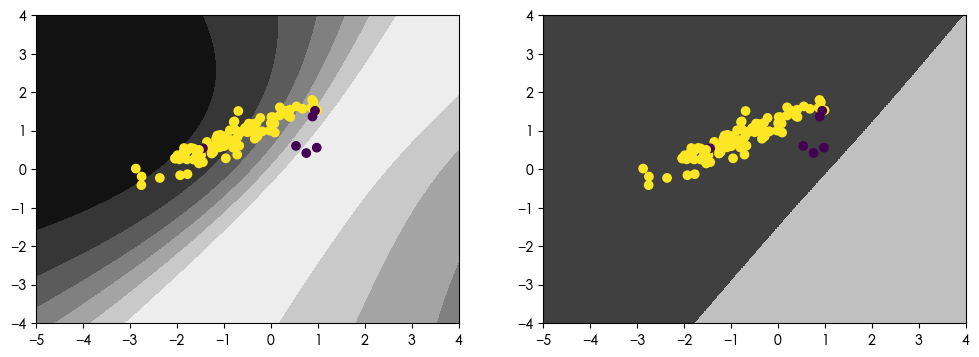

In [8]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.contourf(xx, yy, (-np.sum(y_prob * np.exp(y_prob), axis=1)).reshape(xx.shape), cmap='gray')
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.subplot(122)
plt.contourf(xx, yy, np.exp(y_prob[:, 0] - y_prob[:, 1]).reshape(xx.shape) > 1, cmap='gray')
plt.scatter(X[:, 0], X[:, 1], c=y);

After rescaling:

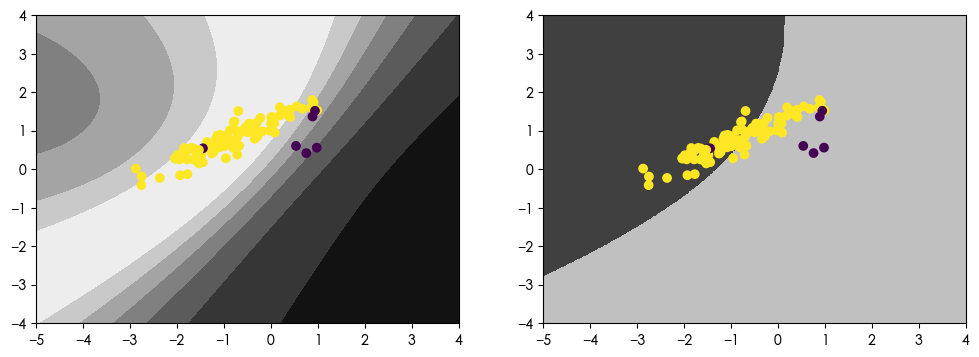

In [9]:
y_prior = np.log(np.array([0.05, 0.95]))  # the class prior
y_postfix = np.exp(y_prob - y_prior)
y_postfix /= np.sum(y_postfix, axis=1, keepdims=True)
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.contourf(xx, yy, (-np.sum(y_postfix * np.log(y_postfix), axis=1)).reshape(xx.shape), cmap='gray')
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.subplot(122)
plt.contourf(xx, yy, np.exp(y_prob[:, 0] - y_prob[:, 1]).reshape(xx.shape) > 0.05/0.95, cmap='gray')
plt.scatter(X[:, 0], X[:, 1], c=y);

## Strengthen the prior

In [10]:
def log_prior(z):
    var = np.array([1, 1, 1, 1, 1e-6, 1e-6])
    return -jnp.dot(z / var, z) / 2

Learn the model and make prediction.

In [11]:
_, _, theta, log_sigma2 = train_and_eval_elbo(key, data, data, params)
# To raise the resolution, change 500 to, e.g. 800, which also increase memory footprint.
xx, yy = np.meshgrid(np.linspace(-5, 4, 500), np.linspace(-4, 4, 500))
x = np.c_[xx.ravel(), yy.ravel()]
y_prob = estimate_predictive_posterior(
    key, theta, log_sigma2, x, params['n_mc_pp'], params['input_dim'], params['mixing_dim'],
    (params['input_dim'] + 1) * params['n_class'], params['n_class'])

ep   0 elbo=-1.362e+06 acc=0.880
  ba     1 elbo=-1.347e+06
ep   1 elbo=-1.356e+06 acc=0.870
  ba     1 elbo=-1.065e+06
ep   2 elbo=-1.093e+06 acc=0.880
  ba     1 elbo=-9.683e+05
ep   3 elbo=-9.986e+05 acc=0.860
  ba     1 elbo=-8.179e+05
ep   4 elbo=-9.138e+05 acc=0.880
  ba     1 elbo=-6.606e+05
ep   5 elbo=-7.499e+05 acc=0.880
  ba     1 elbo=-6.076e+05
ep   6 elbo=-6.113e+05 acc=0.880
  ba     1 elbo=-5.335e+05
ep   7 elbo=-5.392e+05 acc=0.880
  ba     1 elbo=-4.802e+05
ep   8 elbo=-4.930e+05 acc=0.880
  ba     1 elbo=-4.726e+05
ep   9 elbo=-5.667e+05 acc=0.880
  ba     1 elbo=-4.574e+05
ep  10 elbo=-4.202e+05 acc=0.880
  ba     1 elbo=-2.905e+05
ep  11 elbo=-4.578e+05 acc=0.880
  ba     1 elbo=-3.432e+05
ep  12 elbo=-3.846e+05 acc=0.900
  ba     1 elbo=-2.921e+05
ep  13 elbo=-3.402e+05 acc=0.910
  ba     1 elbo=-2.974e+05
ep  14 elbo=-2.761e+05 acc=0.930
  ba     1 elbo=-2.828e+05
ep  15 elbo=-2.620e+05 acc=0.930
  ba     1 elbo=-2.381e+05
ep  16 elbo=-2.467e+05 acc=0.940
  ba   

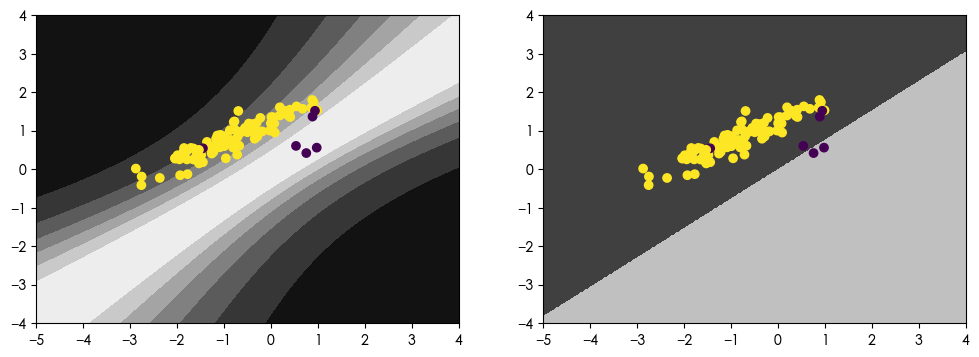

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.contourf(xx, yy, (-np.sum(y_prob * np.exp(y_prob), axis=1)).reshape(xx.shape), cmap='gray')
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.subplot(122)
plt.contourf(xx, yy, np.exp(y_prob[:, 0] - y_prob[:, 1]).reshape(xx.shape) > 1, cmap='gray')
plt.scatter(X[:, 0], X[:, 1], c=y);

## Bias the prior

In [13]:
def log_prior(z):
    mu = np.array([0, 0, 0, 0, 2, 0])
    var = np.array([1, 1, 1, 1, 1e-6, 1e-6])
    return -jnp.dot((z - mu) / var, z - mu) / 2

Learn the model and make prediction.

In [14]:
_, _, theta, log_sigma2 = train_and_eval_elbo(key, data, data, params)
# To raise the resolution, change 500 to, e.g. 800, which also increase memory footprint.
xx, yy = np.meshgrid(np.linspace(-5, 4, 500), np.linspace(-4, 4, 500))
x = np.c_[xx.ravel(), yy.ravel()]
y_prob = estimate_predictive_posterior(
    key, theta, log_sigma2, x, params['n_mc_pp'], params['input_dim'], params['mixing_dim'],
    (params['input_dim'] + 1) * params['n_class'], params['n_class'])

ep   0 elbo=-5.968e+06 acc=0.880
  ba     1 elbo=-5.880e+06
ep   1 elbo=-6.016e+06 acc=0.860
  ba     1 elbo=-5.390e+06
ep   2 elbo=-5.503e+06 acc=0.860
  ba     1 elbo=-5.165e+06
ep   3 elbo=-5.300e+06 acc=0.850
  ba     1 elbo=-4.783e+06
ep   4 elbo=-5.052e+06 acc=0.880
  ba     1 elbo=-4.482e+06
ep   5 elbo=-4.577e+06 acc=0.880
  ba     1 elbo=-4.193e+06
ep   6 elbo=-4.224e+06 acc=0.860
  ba     1 elbo=-4.025e+06
ep   7 elbo=-3.997e+06 acc=0.880
  ba     1 elbo=-3.760e+06
ep   8 elbo=-3.820e+06 acc=0.880
  ba     1 elbo=-3.754e+06
ep   9 elbo=-3.906e+06 acc=0.880
  ba     1 elbo=-3.620e+06
ep  10 elbo=-3.586e+06 acc=0.880
  ba     1 elbo=-3.073e+06
ep  11 elbo=-3.624e+06 acc=0.880
  ba     1 elbo=-3.193e+06
ep  12 elbo=-3.311e+06 acc=0.880
  ba     1 elbo=-2.978e+06
ep  13 elbo=-3.043e+06 acc=0.890
  ba     1 elbo=-2.982e+06
ep  14 elbo=-2.639e+06 acc=0.910
  ba     1 elbo=-2.745e+06
ep  15 elbo=-2.693e+06 acc=0.930
  ba     1 elbo=-2.496e+06
ep  16 elbo=-2.456e+06 acc=0.930
  ba   

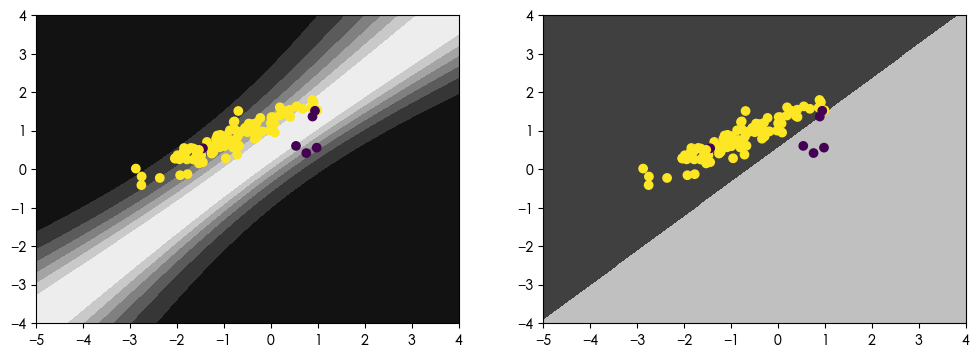

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.contourf(xx, yy, (-np.sum(y_prob * np.exp(y_prob), axis=1)).reshape(xx.shape), cmap='gray')
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.subplot(122)
plt.contourf(xx, yy, np.exp(y_prob[:, 0] - y_prob[:, 1]).reshape(xx.shape) > 1, cmap='gray')
plt.scatter(X[:, 0], X[:, 1], c=y);